In [1]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
#% matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
adult_df = pd.read_csv('adult.csv')
print("Number of Observations in adult dataset:", adult_df.shape)

adult_df.head()

Number of Observations in adult dataset: (32561, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [5]:
print(f"Number of columns before deleting: {adult_df.shape[1]}")

del_cols = ['relationship','education.num']
adult_df.drop(labels = del_cols,axis = 1,inplace = True)
print(f"Number of columns after deleting: {adult_df.shape[1]}")

Number of columns before deleting: 15
Number of columns after deleting: 13


In [6]:
hrs_per_week = adult_df[adult_df['hours.per.week'] == 99]
print("Number of people working for 99 hours per week:", hrs_per_week.shape[0])


Number of people working for 99 hours per week: 85


In [7]:
# drop rows with age 90
print("Number of observation before removing:",adult_df.shape)
index_age = adult_df[adult_df['age'] == 90].index
adult_df.drop(labels = index_age,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df.shape)

Number of observation before removing: (32561, 13)
Number of observation after removing: (32518, 13)


In [8]:
print("Number of observation before removing:",adult_df.shape)
index_gain = adult_df[adult_df['capital.gain'] == 99999].index
adult_df.drop(labels = index_gain,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df.shape)

Number of observation before removing: (32518, 13)
Number of observation after removing: (32359, 13)


In [10]:
num_col_new = ['age','capital.gain', 'capital.loss',
       'hours.per.week','fnlwgt']
cat_col_new = ['workclass', 'education', 'marital.status', 'occupation',
               'race', 'sex', 'native.country', 'income']

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
pd.DataFrame(scaler.fit_transform(adult_df[num_col_new]),columns = num_col_new).head(3)

,age,capital.gain,capital.loss,hours.per.week,fnlwgt
0,0.915493,0.0,1.000000,0.173469,0.081896
1,0.690141,0.0,1.000000,0.397959,0.118021
2,0.521127,0.0,0.895317,0.397959,0.086982


In [12]:
class DataFrameSelector(TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        return X[self.attribute_names]


class num_trans(TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        df = pd.DataFrame(X)
        df.columns = num_col_new
        return df



pipeline = Pipeline([('selector',DataFrameSelector(num_col_new)),
                     ('scaler',MinMaxScaler()),
                    ('transform',num_trans())])



In [13]:
num_df = pipeline.fit_transform(adult_df)
num_df.shape

(32359, 5)

In [14]:
# columns which I don't need after creating dummy variables dataframe
cols = ['workclass_Govt_employess','education_Some-college',
        'marital.status_Never-married','occupation_Other-service',
        'race_Black','sex_Male','income_>50K']

In [15]:
class dummies(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        df = pd.get_dummies(X)
        df_new = df[df.columns.difference(cols)]
#difference returns the original columns, with the columns passed as argument removed.
        return df_new

pipeline_cat=Pipeline([('selector',DataFrameSelector(cat_col_new)),
                      ('dummies',dummies(cols))])
cat_df = pipeline_cat.fit_transform(adult_df)
cat_df.shape

(32359, 92)

In [17]:
cat_df['id'] = pd.Series(range(cat_df.shape[0]))
num_df['id'] = pd.Series(range(num_df.shape[0]))
final_df = pd.merge(cat_df,num_df,how = 'inner', on = 'id')
print(f"Number of observations in final dataset: {final_df.shape}")


Number of observations in final dataset: (32157, 98)


## Train and Fine Tuning on the model

In [18]:
y = final_df['income_<=50K']
final_df.drop(labels = ['id','income_<=50K'],axis = 1,inplace = True)
X = final_df

In [20]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc
from datetime import datetime
from sklearn.feature_selection import RFE

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.25,random_state = 42)
#Instantiate the classifiers
clf_logreg = LogisticRegression()
clf_tree = DecisionTreeClassifier()
clf_knn =  KNeighborsClassifier()
clf_gnb = GaussianNB()
classifiers = ['LogisticRegression', 'DecisionTree', 'KNN', 'SVC', 'Naive']
models = {clf_logreg:'LogisticRegression',
          clf_tree:'DecisionTree',
          clf_knn: 'KNN',
          clf_gnb: 'Naive'}
# train function fits the model and returns accuracy score
def train(algo,name,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    print(f"--------------------------------------------{name}---------------------------------------------------")
    print(f"Accuracy Score for {name}: {score*100:.4f}%")
    return y_test,y_pred,score

# acc_res function calculates confusion matrix
def acc_res(y_test,y_pred):
    null_accuracy = y_test.value_counts()[0]/len(y_test)
    print(f"Null Accuracy: {null_accuracy*100:.4f}%")
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,y_pred)
    print(matrix)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    accuracy_score=(TN+TP) / float(TP+TN+FP+FN)
    recall_score = (TP)/ float(TP+FN)
    specificity = TN / float(TN+FP)
    FPR = FP / float(FP+TN)
    precision_score = TP / float(TP+FP)
    print(f"Accuracy Score: {accuracy_score*100:.4f}%")
    print(f"Recall Score: {recall_score*100:.4f}%")
    print(f"Specificity Score: {specificity*100:.4f}%")
    print(f"False Positive Rate: {FPR*100:.4f}%")
    print(f"Precision Score: {precision_score*100:.4f}%")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Classification Report")
    print(classification_report(y_test,y_pred))

def main(models):
    accuracy_scores = []
    for algo,name in models.items():
        y_test_train,y_pred,acc_score = train(algo,name,X_train,y_train,X_test,y_test)
        acc_res(y_test_train,y_pred)
        accuracy_scores.append(acc_score)
    return accuracy_scores

accuracy_scores = main(models)


--------------------------------------------LogisticRegression---------------------------------------------------
Accuracy Score for LogisticRegression: 84.3781%
Null Accuracy: 76.5050%
Confusion Matrix
[[1061  828]
 [ 428 5723]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 84.3781%
Recall Score: 93.0418%
Specificity Score: 56.1673%
False Positive Rate: 43.8327%
Precision Score: 87.3607%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.71      0.56      0.63      1889
        True       0.87      0.93      0.90      6151

    accuracy                           0.84      8040
   macro avg       0.79      0.75      0.76      8040
weighted avg       0.84      0.84      0.84      8040



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_53439/2512564111.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------DecisionTree---------------------------------------------------
Accuracy Score for DecisionTree: 80.3358%
Null Accuracy: 76.5050%
Confusion Matrix
[[1095  794]
 [ 787 5364]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 80.3358%
Recall Score: 87.2053%
Specificity Score: 57.9672%
False Positive Rate: 42.0328%
Precision Score: 87.1062%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.58      0.58      0.58      1889
        True       0.87      0.87      0.87      6151

    accuracy                           0.80      8040
   macro avg       0.73      0.73      0.73      8040
weighted avg       0.80      0.80      0.80      8040



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_53439/2512564111.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------KNN---------------------------------------------------
Accuracy Score for KNN: 81.5920%
Null Accuracy: 76.5050%
Confusion Matrix
[[ 966  923]
 [ 557 5594]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 81.5920%
Recall Score: 90.9446%
Specificity Score: 51.1382%
False Positive Rate: 48.8618%
Precision Score: 85.8370%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.63      0.51      0.57      1889
        True       0.86      0.91      0.88      6151

    accuracy                           0.82      8040
   macro avg       0.75      0.71      0.72      8040
weighted avg       0.81      0.82      0.81      8040

--------------------------------------------Naive---------------------------------------------------
Accuracy Score for Naive: 36.9154%
Null Accuracy: 76.5050%
Confusi

/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_53439/2512564111.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)
/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_53439/2512564111.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


## Get the Data - Gaussian Noise: Normal Scale

In [22]:
import numpy as np
import pandas as pd

adult_df_gaussian = pd.read_csv('adult.csv')
print("Number of Observations in adult dataset:", adult_df.shape)

# Add Gaussian noise directly to the 'age' column
adult_df_gaussian['age'] += np.random.normal(loc=0, scale=10, size=adult_df_gaussian['age'].shape)

# Add Gaussian noise directly to the 'capital_gain' column
adult_df_gaussian['capital.gain'] += np.random.normal(loc=0, scale=1000, size=adult_df_gaussian['capital.gain'].shape)

# Add Gaussian noise directly to the 'hours_per_week' column
adult_df_gaussian['hours.per.week'] += np.random.normal(loc=0, scale=4, size=adult_df_gaussian['hours.per.week'].shape)

adult_df_gaussian.head()

Number of Observations in adult dataset: (32359, 13)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,111.288322,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,466.235794,4356,42.123067,United-States,<=50K
1,70.037841,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,-370.453862,4356,18.349390,United-States,<=50K
2,59.705940,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,2288.364667,4356,43.154648,United-States,<=50K
3,51.265883,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,-615.912824,3900,49.636988,United-States,<=50K
4,42.341461,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,-796.965500,3900,43.372420,United-States,<=50K


## Preparing Data for ML Algorithms - Gaussian Noise Normal Scale

In [23]:
# Delete columns
del_cols_gaussian = ['relationship','education.num']
adult_df_gaussian.drop(labels = del_cols,axis = 1,inplace = True)

hrs_per_week_gaussian = adult_df_gaussian[adult_df_gaussian['hours.per.week'] == 99]

# drop rows with age 90
print("Number of observation before removing:",adult_df_gaussian.shape)
index_age_gaussian = adult_df_gaussian[adult_df_gaussian['age'] == 90].index
adult_df_gaussian.drop(labels = index_age_gaussian,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_gaussian.shape)

print("Number of observation before removing:",adult_df_gaussian.shape)
index_gain_gaussian = adult_df_gaussian[adult_df_gaussian['capital.gain'] == 99999].index
adult_df_gaussian.drop(labels = index_gain_gaussian,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_gaussian.shape)

num_col_new_gaussian = ['age','capital.gain', 'capital.loss',
       'hours.per.week','fnlwgt']
cat_col_new_gaussian = ['workclass', 'education', 'marital.status', 'occupation',
               'race', 'sex', 'native.country', 'income']

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler_gaussian = MinMaxScaler()
pd.DataFrame(scaler_gaussian.fit_transform(adult_df_gaussian[num_col_new_gaussian]),columns = num_col_new_gaussian).head(3)

class DataFrameSelector(TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        return X[self.attribute_names]


class num_trans(TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        df = pd.DataFrame(X)
        df.columns = num_col_new
        return df



pipeline_gaussian = Pipeline([('selector',DataFrameSelector(num_col_new)),
                     ('scaler',MinMaxScaler()),
                    ('transform',num_trans())])

num_df_gaussian = pipeline_gaussian.fit_transform(adult_df_gaussian)
num_df_gaussian.shape

# columns which I don't need after creating dummy variables dataframe
cols_gaussian = ['workclass_Govt_employess','education_Some-college',
        'marital.status_Never-married','occupation_Other-service',
        'race_Black','sex_Male','income_>50K']

class dummies(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols_gaussian

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        df_gaussian = pd.get_dummies(X)
        df_new_gaussian = df_gaussian[df_gaussian.columns.difference(cols)]
#difference returns the original columns, with the columns passed as argument removed.
        return df_new_gaussian

pipeline_cat_gaussian=Pipeline([('selector',DataFrameSelector(cat_col_new)),
                      ('dummies',dummies(cols))])
cat_df_gaussian = pipeline_cat_gaussian.fit_transform(adult_df_gaussian)
cat_df_gaussian.shape

cat_df_gaussian['id'] = pd.Series(range(cat_df_gaussian.shape[0]))
num_df_gaussian['id'] = pd.Series(range(num_df_gaussian.shape[0]))

final_df_gaussian = pd.merge(cat_df_gaussian,num_df_gaussian,how = 'inner', on = 'id')
print(f"Number of observations in final dataset: {final_df_gaussian.shape}")

Number of observation before removing: (32561, 13)
Number of observation after removing: (32561, 13)
Number of observation before removing: (32561, 13)
Number of observation after removing: (32561, 13)
Number of observations in final dataset: (32561, 98)


## Train and Fine Tuning on the model - Gaussian Noise Normal Scale

In [24]:
y = final_df_gaussian['income_<=50K']
final_df_gaussian.drop(labels = ['id','income_<=50K'],axis = 1,inplace = True)
X = final_df_gaussian

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc
from datetime import datetime
from sklearn.feature_selection import RFE

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.25,random_state = 42)

#Instantiate the classifiers
clf_logreg = LogisticRegression()
clf_tree = DecisionTreeClassifier()
clf_knn =  KNeighborsClassifier()
clf_gnb = GaussianNB()

classifiers = ['LogisticRegression', 'DecisionTree', 'KNN', 'SVC', 'Naive']

models = {clf_logreg:'LogisticRegression',
          clf_tree:'DecisionTree',
          clf_knn: 'KNN',
          clf_gnb: 'Naive'}

# train function fits the model and returns accuracy score
def train(algo,name,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    print(f"--------------------------------------------{name}---------------------------------------------------")
    print(f"Accuracy Score for {name}: {score*100:.4f}%")
    return y_test,y_pred,score

# acc_res function calculates confusion matrix
def acc_res(y_test,y_pred):
    null_accuracy = y_test.value_counts()[0]/len(y_test)
    print(f"Null Accuracy: {null_accuracy*100:.4f}%")
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,y_pred)
    print(matrix)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    accuracy_score=(TN+TP) / float(TP+TN+FP+FN)
    recall_score = (TP)/ float(TP+FN)
    specificity = TN / float(TN+FP)
    FPR = FP / float(FP+TN)
    precision_score = TP / float(TP+FP)
    print(f"Accuracy Score: {accuracy_score*100:.4f}%")
    print(f"Recall Score: {recall_score*100:.4f}%")
    print(f"Specificity Score: {specificity*100:.4f}%")
    print(f"False Positive Rate: {FPR*100:.4f}%")
    print(f"Precision Score: {precision_score*100:.4f}%")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Classification Report")
    print(classification_report(y_test,y_pred))

def main(models):
    accuracy_scores = []
    for algo,name in models.items():
        y_test_train,y_pred,acc_score = train(algo,name,X_train,y_train,X_test,y_test)
        acc_res(y_test_train,y_pred)
        accuracy_scores.append(acc_score)
    return accuracy_scores

accuracy_scores = main(models)

--------------------------------------------LogisticRegression---------------------------------------------------
Accuracy Score for LogisticRegression: 84.2894%
Null Accuracy: 76.1209%
Confusion Matrix
[[1084  860]
 [ 419 5778]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 84.2894%
Recall Score: 93.2387%
Specificity Score: 55.7613%
False Positive Rate: 44.2387%
Precision Score: 87.0443%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.72      0.56      0.63      1944
        True       0.87      0.93      0.90      6197

    accuracy                           0.84      8141
   macro avg       0.80      0.74      0.76      8141
weighted avg       0.83      0.84      0.84      8141



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_53439/1999007911.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------DecisionTree---------------------------------------------------
Accuracy Score for DecisionTree: 79.8428%
Null Accuracy: 76.1209%
Confusion Matrix
[[1142  802]
 [ 839 5358]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 79.8428%
Recall Score: 86.4612%
Specificity Score: 58.7449%
False Positive Rate: 41.2551%
Precision Score: 86.9805%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.58      0.59      0.58      1944
        True       0.87      0.86      0.87      6197

    accuracy                           0.80      8141
   macro avg       0.72      0.73      0.72      8141
weighted avg       0.80      0.80      0.80      8141



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_53439/1999007911.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------KNN---------------------------------------------------
Accuracy Score for KNN: 81.2185%
Null Accuracy: 76.1209%
Confusion Matrix
[[1022  922]
 [ 607 5590]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 81.2185%
Recall Score: 90.2049%
Specificity Score: 52.5720%
False Positive Rate: 47.4280%
Precision Score: 85.8415%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.63      0.53      0.57      1944
        True       0.86      0.90      0.88      6197

    accuracy                           0.81      8141
   macro avg       0.74      0.71      0.73      8141
weighted avg       0.80      0.81      0.81      8141

--------------------------------------------Naive---------------------------------------------------
Accuracy Score for Naive: 35.0694%
Null Accuracy: 76.1209%
Confusi

/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_53439/1999007911.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)
/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_53439/1999007911.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


## Reidentification: Normal noise

Re-identification Rate: 0.39%


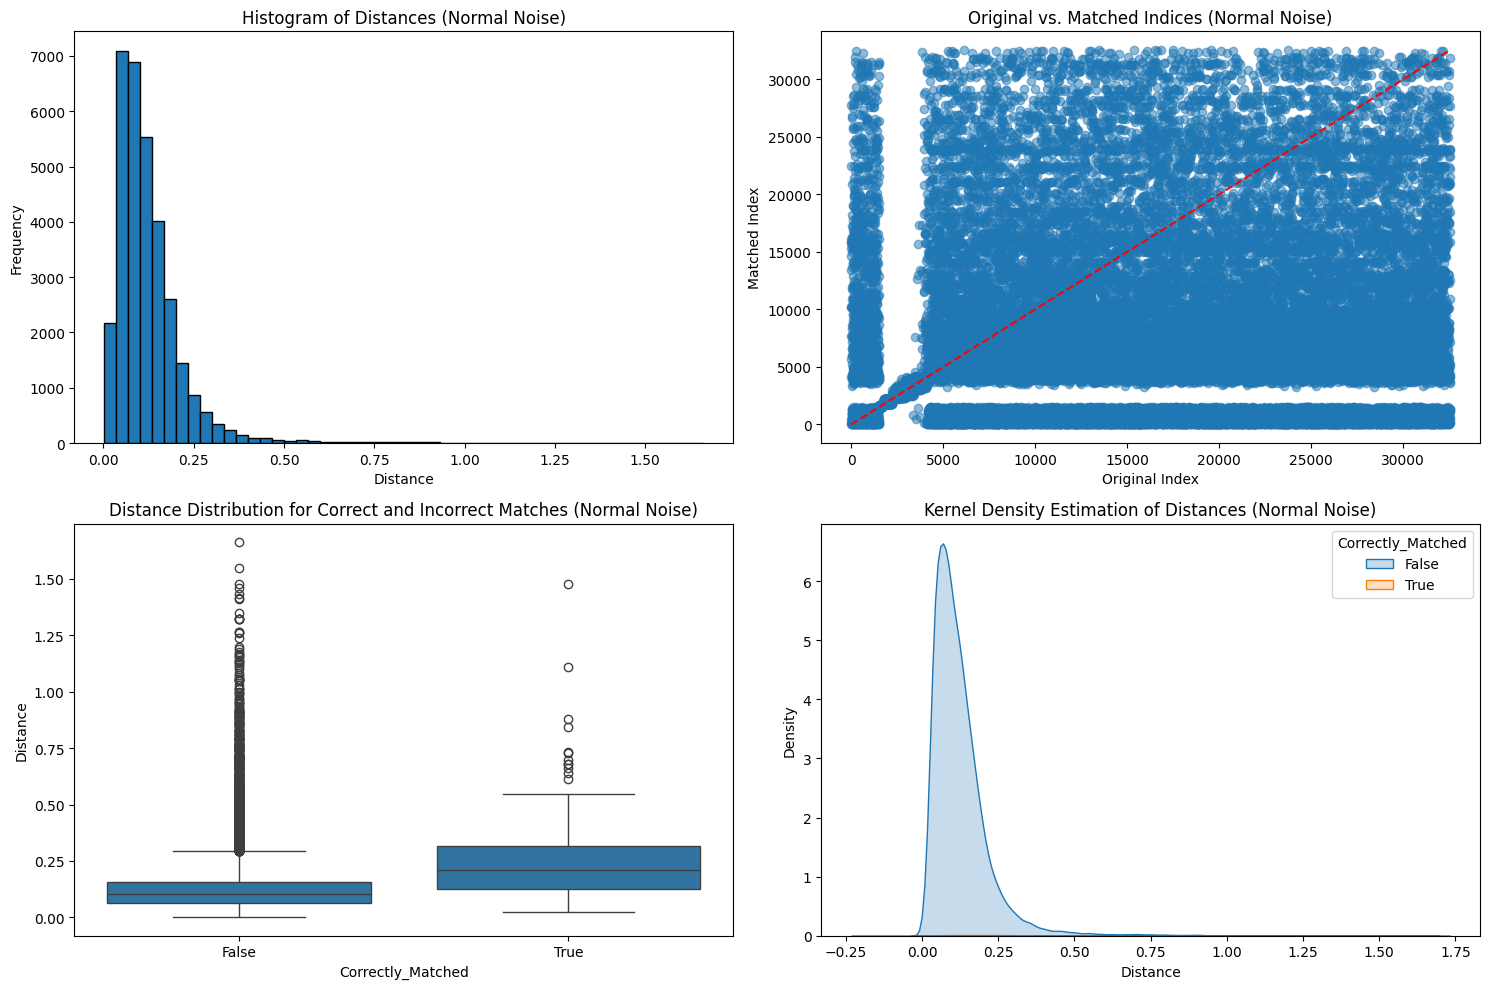

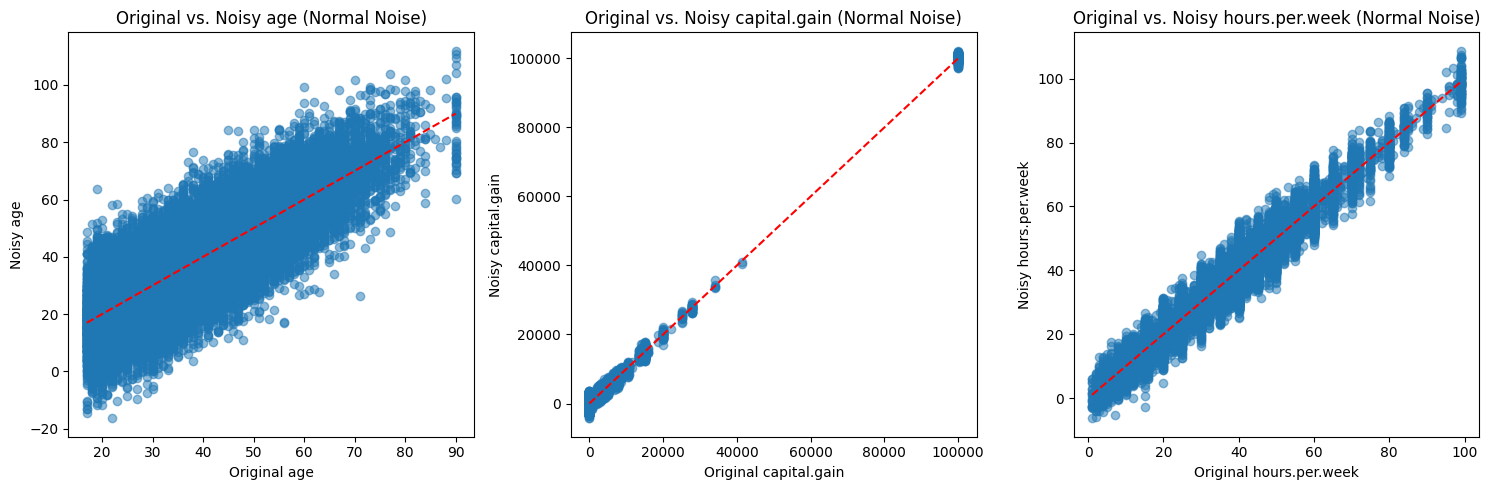


Distance Statistics:
Mean Distance: 0.1254
Median Distance: 0.1027
Min Distance: 0.0025
Max Distance: 1.6605

Correct Matches: 126
Total Records: 32561
Re-identification Rate: 0.39%


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances_argmin_min

# Load the original dataset
adult_df_original = pd.read_csv('adult.csv')

# Create a copy for adding normal noise
adult_df_normal_noise = adult_df_original.copy()

# Add normal Gaussian noise
np.random.seed(42)  # for reproducibility
adult_df_normal_noise['age'] += np.random.normal(loc=0, scale=10, size=adult_df_normal_noise['age'].shape)
adult_df_normal_noise['capital.gain'] += np.random.normal(loc=0, scale=1000, size=adult_df_normal_noise['capital.gain'].shape)
adult_df_normal_noise['hours.per.week'] += np.random.normal(loc=0, scale=4, size=adult_df_normal_noise['hours.per.week'].shape)

# Columns to compare
cols_to_compare = ['age', 'capital.gain', 'hours.per.week']

def normalize(df, cols):
    return (df[cols] - df[cols].mean()) / df[cols].std()

original_normalized = normalize(adult_df_original, cols_to_compare)
normal_noise_normalized = normalize(adult_df_normal_noise, cols_to_compare)

# Finding the closest match
indices, distances = pairwise_distances_argmin_min(normal_noise_normalized, original_normalized)

# Calculate true re-identification rate (correct matches)
correct_matches = sum(np.arange(len(adult_df_original)) == indices)
reidentification_rate = correct_matches / len(adult_df_original)

print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

# Create results dataframe
results_df = pd.DataFrame({
    'Original_Index': np.arange(len(adult_df_original)),
    'Matched_Index': indices,
    'Distance': distances,
    'Correctly_Matched': np.arange(len(adult_df_original)) == indices
})

# Visualizations
plt.figure(figsize=(15, 10))


# 1. Histogram of Distances
plt.subplot(2, 2, 1)
plt.hist(distances, bins=50, edgecolor='black')
plt.title('Histogram of Distances (Normal Noise)')
plt.xlabel('Distance')
plt.ylabel('Frequency')

# 2. Scatter Plot of Original vs. Matched Indices
plt.subplot(2, 2, 2)
plt.scatter(results_df['Original_Index'], results_df['Matched_Index'], alpha=0.5)
plt.title('Original vs. Matched Indices (Normal Noise)')
plt.xlabel('Original Index')
plt.ylabel('Matched Index')
plt.plot([0, len(adult_df_original)], [0, len(adult_df_original)], 'r--')  # Diagonal line for perfect matches

# 3. Box Plot of Distances for Correct and Incorrect Matches
plt.subplot(2, 2, 3)
sns.boxplot(x='Correctly_Matched', y='Distance', data=results_df)
plt.title('Distance Distribution for Correct and Incorrect Matches (Normal Noise)')

# 4. KDE Plot of Distances
plt.subplot(2, 2, 4)
sns.kdeplot(data=results_df, x='Distance', hue='Correctly_Matched', fill=True)
plt.title('Kernel Density Estimation of Distances (Normal Noise)')

plt.tight_layout()
plt.show()

# 5. Feature Comparison Plot
plt.figure(figsize=(15, 5))
for i, col in enumerate(cols_to_compare):
    plt.subplot(1, 3, i+1)
    plt.scatter(adult_df_original[col], adult_df_normal_noise[col], alpha=0.5)
    plt.title(f'Original vs. Noisy {col} (Normal Noise)')
    plt.xlabel(f'Original {col}')
    plt.ylabel(f'Noisy {col}')
    plt.plot([adult_df_original[col].min(), adult_df_original[col].max()], 
             [adult_df_original[col].min(), adult_df_original[col].max()], 'r--')
plt.tight_layout()
plt.show()

# Print additional statistics
print("\nDistance Statistics:")
print(f"Mean Distance: {np.mean(distances):.4f}")
print(f"Median Distance: {np.median(distances):.4f}")
print(f"Min Distance: {np.min(distances):.4f}")
print(f"Max Distance: {np.max(distances):.4f}")

print("\nCorrect Matches:", correct_matches)
print("Total Records:", len(adult_df_original))
print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

## Get the Data - Gaussian Noise: Scale Doubled

In [8]:
import numpy as np
import pandas as pd

adult_df_gaussian_num_doubled = pd.read_csv('adult.csv')
print("Number of Observations in adult dataset:", adult_df_gaussian_num_doubled.shape)

# Add Gaussian noise directly to the 'age' column
adult_df_gaussian_num_doubled['age'] += np.random.normal(loc=0, scale=20, size=adult_df_gaussian_num_doubled['age'].shape)

# Add Gaussian noise directly to the 'capital_gain' column
adult_df_gaussian_num_doubled['capital.gain'] += np.random.normal(loc=0, scale=2000, size=adult_df_gaussian_num_doubled['capital.gain'].shape)

# Add Gaussian noise directly to the 'hours_per_week' column
adult_df_gaussian_num_doubled['hours.per.week'] += np.random.normal(loc=0, scale=8, size=adult_df_gaussian_num_doubled['hours.per.week'].shape)

adult_df_gaussian_num_doubled.head()

Number of Observations in adult dataset: (32561, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,64.173122,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,865.542146,4356,35.074889,United-States,<=50K
1,81.565386,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,-1963.501084,4356,9.481541,United-States,<=50K
2,65.912930,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,-512.760016,4356,39.373534,United-States,<=50K
3,59.142174,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,-1788.203212,3900,37.662230,United-States,<=50K
4,12.116003,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,-107.309137,3900,38.990266,United-States,<=50K


## Preparing Data for ML Algorithms - Gaussian Noise Scale Doubled

In [16]:
hrs_per_week_gaussian_num_doubled = adult_df_gaussian_num_doubled[adult_df_gaussian_num_doubled['hours.per.week'] == 99]

# drop rows with age 90
print("Number of observation before removing:",adult_df_gaussian_num_doubled.shape)
index_age_gaussian_num_doubled = adult_df_gaussian_num_doubled[adult_df_gaussian_num_doubled['age'] == 90].index
adult_df_gaussian_num_doubled.drop(labels = index_age_gaussian_num_doubled,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_gaussian_num_doubled.shape)

print("Number of observation before removing:",adult_df_gaussian_num_doubled.shape)
index_gain_gaussian_num_doubled = adult_df_gaussian_num_doubled[adult_df_gaussian_num_doubled['capital.gain'] == 99999].index
adult_df_gaussian_num_doubled.drop(labels = index_gain_gaussian_num_doubled,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_gaussian_num_doubled.shape)

num_col_new_gaussian_num_doubled = ['age','capital.gain', 'capital.loss',
       'hours.per.week','fnlwgt']
cat_col_new_gaussian_num_doubled = ['workclass', 'education', 'marital.status', 'occupation',
               'race', 'sex', 'native.country', 'income']

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler_gaussian_num_doubled = MinMaxScaler()
pd.DataFrame(scaler_gaussian_num_doubled.fit_transform(adult_df_gaussian_num_doubled[num_col_new_gaussian_num_doubled]),columns = num_col_new_gaussian_num_doubled).head(3)

class DataFrameSelector(TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        return X[self.attribute_names]


class num_trans(TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        df = pd.DataFrame(X)
        df.columns = num_col_new_gaussian_num_doubled
        return df



pipeline_gaussian_num_doubled = Pipeline([('selector',DataFrameSelector(num_col_new_gaussian_num_doubled)),
                     ('scaler',MinMaxScaler()),
                    ('transform',num_trans())])

num_df_gaussian_num_doubled = pipeline_gaussian_num_doubled.fit_transform(adult_df_gaussian_num_doubled)
num_df_gaussian_num_doubled.shape

# columns which I don't need after creating dummy variables dataframe
cols_gaussian_num_doubled = ['workclass_Govt_employess','education_Some-college',
        'marital.status_Never-married','occupation_Other-service',
        'race_Black','sex_Male','income_>50K']

class dummies(TransformerMixin):
    def __init__(self, cols):
        self.cols = cols  # Store the passed columns to self.cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df_gaussian_num_doubled = pd.get_dummies(X)
        # Use self.cols instead of undefined cols
        df_new_gaussian_num_doubled = df_gaussian_num_doubled[df_gaussian_num_doubled.columns.difference(self.cols)]
        return df_new_gaussian_num_doubled


pipeline_cat_gaussian_num_doubled = Pipeline([
    ('selector', DataFrameSelector(cat_col_new_gaussian_num_doubled)),  # Make sure cat_col_new_gaussian_num_doubled is defined
    ('dummies', dummies(cols_gaussian_num_doubled))  # Pass the actual column list here
])

cat_df_gaussian_num_doubled = pipeline_cat_gaussian_num_doubled.fit_transform(adult_df_gaussian_num_doubled)
cat_df_gaussian_num_doubled.shape

cat_df_gaussian_num_doubled['id'] = pd.Series(range(cat_df_gaussian_num_doubled.shape[0]))
num_df_gaussian_num_doubled['id'] = pd.Series(range(num_df_gaussian_num_doubled.shape[0]))

final_df_gaussian_num_doubled = pd.merge(cat_df_gaussian_num_doubled,num_df_gaussian_num_doubled,how = 'inner', on = 'id')
print(f"Number of observations in final dataset: {final_df_gaussian_num_doubled.shape}")

Number of observation before removing: (32561, 15)
Number of observation after removing: (32561, 15)
Number of observation before removing: (32561, 15)
Number of observation after removing: (32561, 15)
Number of observations in final dataset: (32561, 98)


## Train and Fine Tuning on the model - Gaussian Noise Scale Doubled

In [17]:
y = final_df_gaussian_num_doubled['income_<=50K']
final_df_gaussian_num_doubled.drop(labels = ['id','income_<=50K'],axis = 1,inplace = True)
X = final_df_gaussian_num_doubled

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc
from datetime import datetime
from sklearn.feature_selection import RFE

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.25,random_state = 42)

#Instantiate the classifiers
clf_logreg = LogisticRegression()
clf_tree = DecisionTreeClassifier()
clf_knn =  KNeighborsClassifier()
clf_gnb = GaussianNB()

classifiers = ['LogisticRegression', 'DecisionTree', 'KNN', 'SVC', 'Naive']

models = {clf_logreg:'LogisticRegression',
          clf_tree:'DecisionTree',
          clf_knn: 'KNN',
          clf_gnb: 'Naive'}

# train function fits the model and returns accuracy score
def train(algo,name,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    print(f"--------------------------------------------{name}---------------------------------------------------")
    print(f"Accuracy Score for {name}: {score*100:.4f}%")
    return y_test,y_pred,score

# acc_res function calculates confusion matrix
def acc_res(y_test,y_pred):
    null_accuracy = y_test.value_counts()[0]/len(y_test)
    print(f"Null Accuracy: {null_accuracy*100:.4f}%")
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,y_pred)
    print(matrix)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    accuracy_score=(TN+TP) / float(TP+TN+FP+FN)
    recall_score = (TP)/ float(TP+FN)
    specificity = TN / float(TN+FP)
    FPR = FP / float(FP+TN)
    precision_score = TP / float(TP+FP)
    print(f"Accuracy Score: {accuracy_score*100:.4f}%")
    print(f"Recall Score: {recall_score*100:.4f}%")
    print(f"Specificity Score: {specificity*100:.4f}%")
    print(f"False Positive Rate: {FPR*100:.4f}%")
    print(f"Precision Score: {precision_score*100:.4f}%")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Classification Report")
    print(classification_report(y_test,y_pred))

def main(models):
    accuracy_scores = []
    for algo,name in models.items():
        y_test_train,y_pred,acc_score = train(algo,name,X_train,y_train,X_test,y_test)
        acc_res(y_test_train,y_pred)
        accuracy_scores.append(acc_score)
    return accuracy_scores

accuracy_scores = main(models)

--------------------------------------------LogisticRegression---------------------------------------------------
Accuracy Score for LogisticRegression: 83.8226%
Null Accuracy: 76.1209%
Confusion Matrix
[[1052  892]
 [ 425 5772]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 83.8226%
Recall Score: 93.1418%
Specificity Score: 54.1152%
False Positive Rate: 45.8848%
Precision Score: 86.6146%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.71      0.54      0.62      1944
        True       0.87      0.93      0.90      6197

    accuracy                           0.84      8141
   macro avg       0.79      0.74      0.76      8141
weighted avg       0.83      0.84      0.83      8141



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_53488/2095576094.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------DecisionTree---------------------------------------------------
Accuracy Score for DecisionTree: 79.3760%
Null Accuracy: 76.1209%
Confusion Matrix
[[1104  840]
 [ 839 5358]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 79.3760%
Recall Score: 86.4612%
Specificity Score: 56.7901%
False Positive Rate: 43.2099%
Precision Score: 86.4472%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.57      0.57      0.57      1944
        True       0.86      0.86      0.86      6197

    accuracy                           0.79      8141
   macro avg       0.72      0.72      0.72      8141
weighted avg       0.79      0.79      0.79      8141



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_53488/2095576094.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------KNN---------------------------------------------------
Accuracy Score for KNN: 81.1080%
Null Accuracy: 76.1209%
Confusion Matrix
[[ 995  949]
 [ 589 5608]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 81.1080%
Recall Score: 90.4954%
Specificity Score: 51.1831%
False Positive Rate: 48.8169%
Precision Score: 85.5269%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.63      0.51      0.56      1944
        True       0.86      0.90      0.88      6197

    accuracy                           0.81      8141
   macro avg       0.74      0.71      0.72      8141
weighted avg       0.80      0.81      0.80      8141

--------------------------------------------Naive---------------------------------------------------
Accuracy Score for Naive: 34.9097%
Null Accuracy: 76.1209%
Confusi

/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_53488/2095576094.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)
/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_53488/2095576094.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


## Reidentification for Double noise

Re-identification Rate: 0.13%


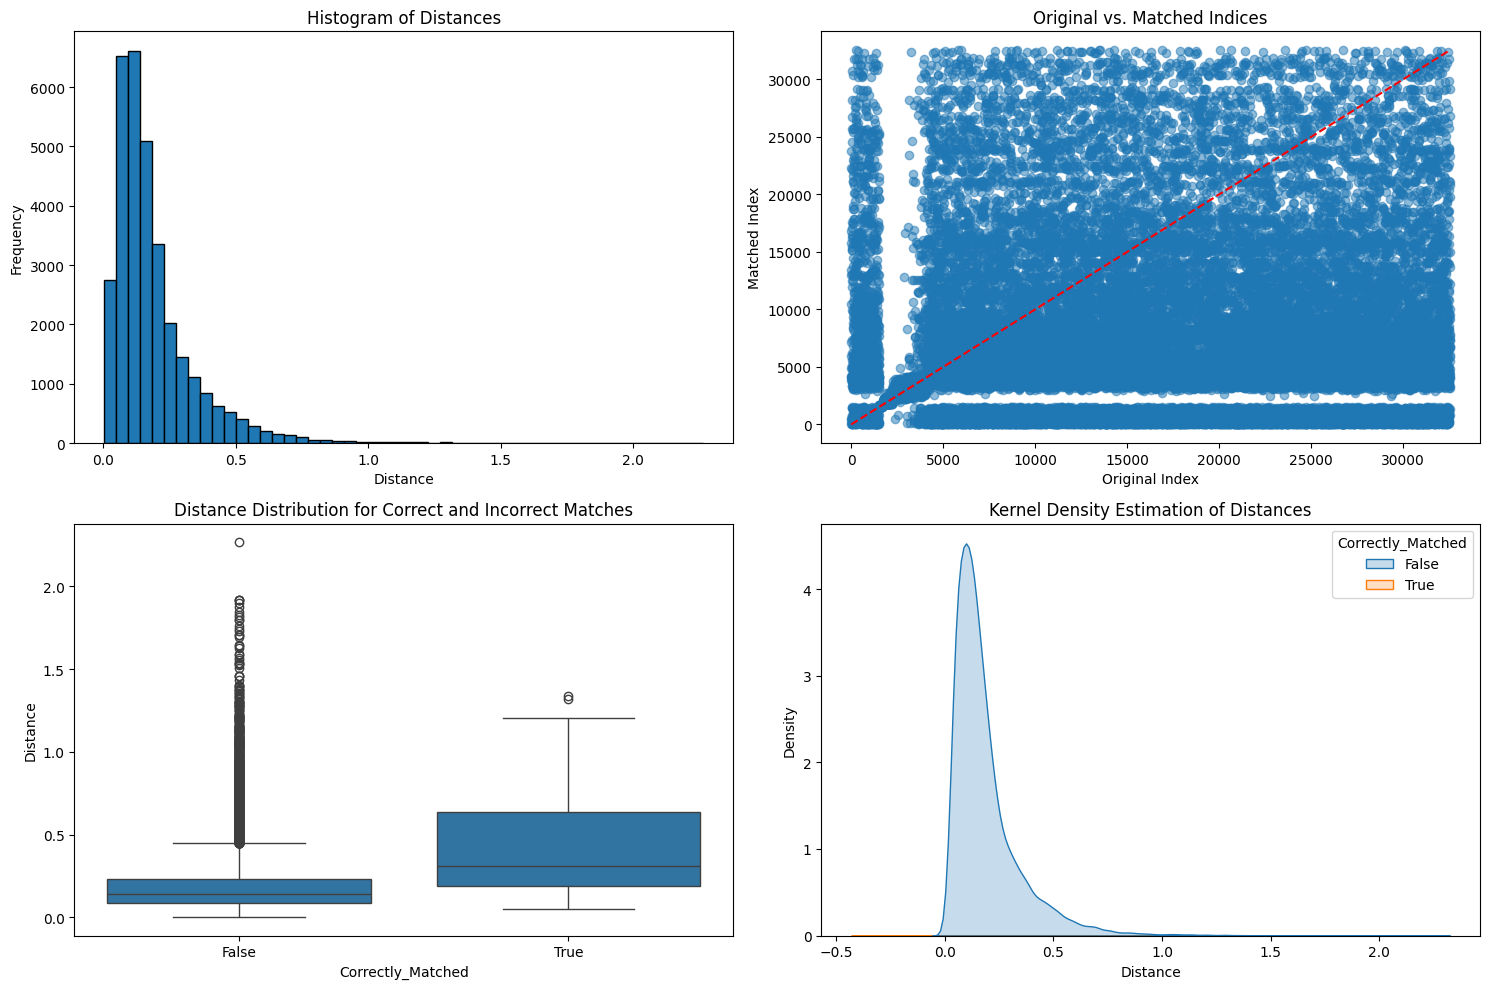

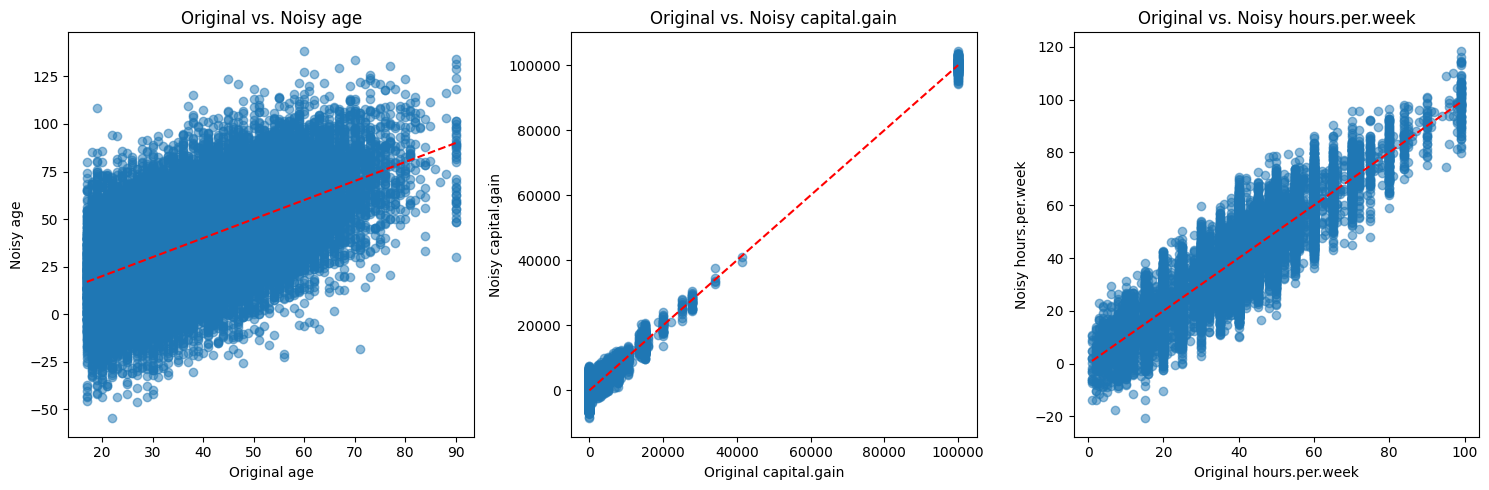


Distance Statistics:
Mean Distance: 0.1894
Median Distance: 0.1422
Min Distance: 0.0034
Max Distance: 2.2652

Correct Matches: 42
Total Records: 32561
Re-identification Rate: 0.13%


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances_argmin_min

# Load the original dataset
adult_df_original = pd.read_csv('adult.csv')

# Create a copy for adding double noise
adult_df_double_noise = adult_df_original.copy()

# Add double Gaussian noise
np.random.seed(42)  # for reproducibility
adult_df_double_noise['age'] += np.random.normal(loc=0, scale=20, size=adult_df_double_noise['age'].shape)
adult_df_double_noise['capital.gain'] += np.random.normal(loc=0, scale=2000, size=adult_df_double_noise['capital.gain'].shape)
adult_df_double_noise['hours.per.week'] += np.random.normal(loc=0, scale=8, size=adult_df_double_noise['hours.per.week'].shape)

# Columns to compare
cols_to_compare = ['age', 'capital.gain', 'hours.per.week']

def normalize(df, cols):
    return (df[cols] - df[cols].mean()) / df[cols].std()

original_normalized = normalize(adult_df_original, cols_to_compare)
double_noise_normalized = normalize(adult_df_double_noise, cols_to_compare)

# Finding the closest match
indices, distances = pairwise_distances_argmin_min(double_noise_normalized, original_normalized)

# Calculate true re-identification rate (correct matches)
correct_matches = sum(np.arange(len(adult_df_original)) == indices)
reidentification_rate = correct_matches / len(adult_df_original)

print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

# Create results dataframe
results_df = pd.DataFrame({
    'Original_Index': np.arange(len(adult_df_original)),
    'Matched_Index': indices,
    'Distance': distances,
    'Correctly_Matched': np.arange(len(adult_df_original)) == indices
})

# Visualizations
plt.figure(figsize=(15, 10))


# 1. Histogram of Distances
plt.subplot(2, 2, 1)
plt.hist(distances, bins=50, edgecolor='black')
plt.title('Histogram of Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')

# 2. Scatter Plot of Original vs. Matched Indices
plt.subplot(2, 2, 2)
plt.scatter(results_df['Original_Index'], results_df['Matched_Index'], alpha=0.5)
plt.title('Original vs. Matched Indices')
plt.xlabel('Original Index')
plt.ylabel('Matched Index')
plt.plot([0, len(adult_df_original)], [0, len(adult_df_original)], 'r--')  # Diagonal line for perfect matches

# 3. Box Plot of Distances for Correct and Incorrect Matches
plt.subplot(2, 2, 3)
sns.boxplot(x='Correctly_Matched', y='Distance', data=results_df)
plt.title('Distance Distribution for Correct and Incorrect Matches')

# 4. KDE Plot of Distances
plt.subplot(2, 2, 4)
sns.kdeplot(data=results_df, x='Distance', hue='Correctly_Matched', fill=True)
plt.title('Kernel Density Estimation of Distances')

plt.tight_layout()
plt.show()

# 5. Feature Comparison Plot
plt.figure(figsize=(15, 5))
for i, col in enumerate(cols_to_compare):
    plt.subplot(1, 3, i+1)
    plt.scatter(adult_df_original[col], adult_df_double_noise[col], alpha=0.5)
    plt.title(f'Original vs. Noisy {col}')
    plt.xlabel(f'Original {col}')
    plt.ylabel(f'Noisy {col}')
    plt.plot([adult_df_original[col].min(), adult_df_original[col].max()], 
             [adult_df_original[col].min(), adult_df_original[col].max()], 'r--')
plt.tight_layout()
plt.show()

# Print additional statistics
print("\nDistance Statistics:")
print(f"Mean Distance: {np.mean(distances):.4f}")
print(f"Median Distance: {np.median(distances):.4f}")
print(f"Min Distance: {np.min(distances):.4f}")
print(f"Max Distance: {np.max(distances):.4f}")

print("\nCorrect Matches:", correct_matches)
print("Total Records:", len(adult_df_original))
print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")